## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 23.4,
 5: 24.9,
 10: 25.6,
 20: 26.6,
 30: 27.4,
 40: 28.7,
 50: 30.3,
 60: 32.1,
 70: 34.0,
 80: 36.5,
 90: 40.0,
 95: 43.0,
 99: 49.10200000000005}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 8.0,
 5: 8.1,
 10: 8.2,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lo

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 23),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1, 4.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.95, 1.03, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1039274.49it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.0004,
 60: 0.00052,
 70: 0.0007,
 80: 0.00104,
 90: 0.00218,
 95: 0.00387,
 99: 0.00976}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.2e+09',
 50: '9.2e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '5.0e+10',
 95: '8.9e+10',
 99: '2.2e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 37.2 log FLOP (~16 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 3.4 years to a max of 0.037716% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.6 max log FLOP (381 septillion) available - TAI takes 37.2 log FLOP (16 thousand decillion) - log $ 18.9 to buy TAI (8 quintillion) vs. willingness to pay log $ 8.3 (191 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (584 septillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 8.4 (233 million) - 18.4 log FLOP per $ (3 quin

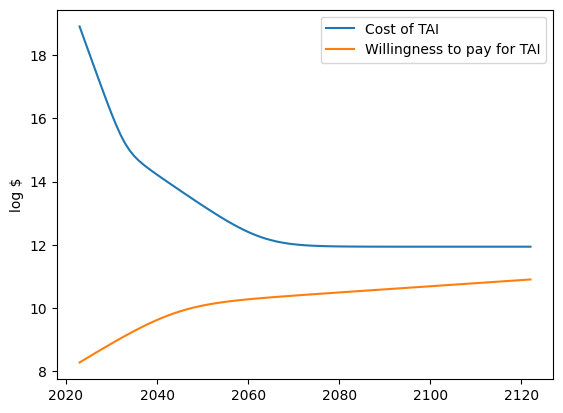

-
-
## SAMPLE RUN 2 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~482 million). This doubles every 3.5 years to a max of 0.05388% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.0 max log FLOP (925 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.7 (464 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.7 (562 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)


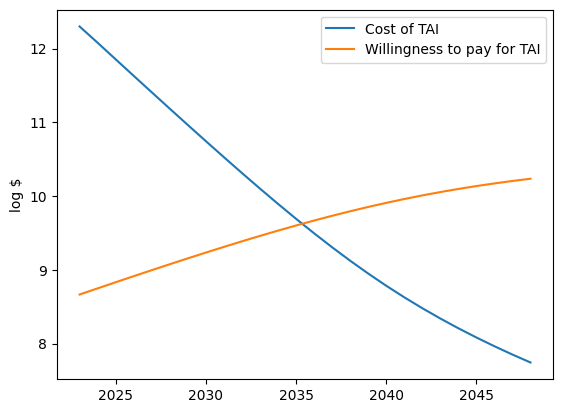

-
-
## SAMPLE RUN 3 ##
It takes 29.5 log FLOP (~316 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~397 million). This doubles every 2.8 years to a max of 0.468365% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.9 max log FLOP (788 septillion) available - TAI takes 29.5 log FLOP (316 octillion) - log $ 11.2 to buy TAI (159 billion) vs. willingness to pay log $ 8.6 (395 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 11.0 to buy TAI (101 billion) vs. willingness to pay log $ 8.7 (505 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFL

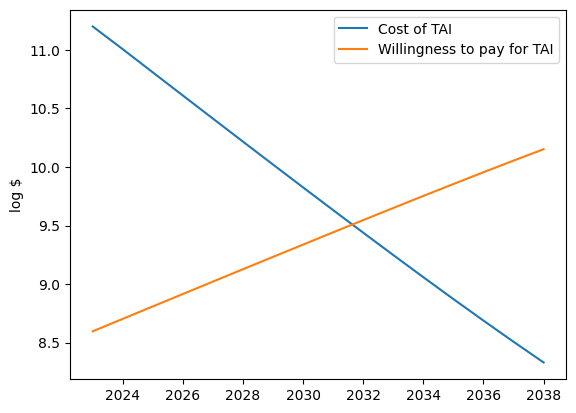

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.35it/s]


Shuffling data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 215.71it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2032',
 '10%: 2034',
 '15%: 2036',
 '20%: 2037',
 '25%: 2038',
 '35%: 2041',
 '50%: 2046',
 '60%: 2051',
 '75%: 2072',
 '80%: 2114',
 '90%: >2123',
 '95%: >2123']
(Mean: 2062)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 9 years from now',
 '10%: 11 years from now',
 '15%: 13 years from now',
 '20%: 14 years from now',
 '25%: 15 years from now',
 '35%: 18 years from now',
 '50%: 23 years from now',
 '60%: 28 years from now',
 '75%: 49 years from now',
 '80%: 91 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 39 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.0%
2028-2029: 1.1%
2030-2034: 9.5%
2035-2039: 20.0%
2040-2049: 27.3%
2050-2059: 11.5%
2060-2069: 5.0%
2070-2079: 2.1%
2080-2089: 1.5%
2090-2099: 1.1%
2100-2109: 0.8

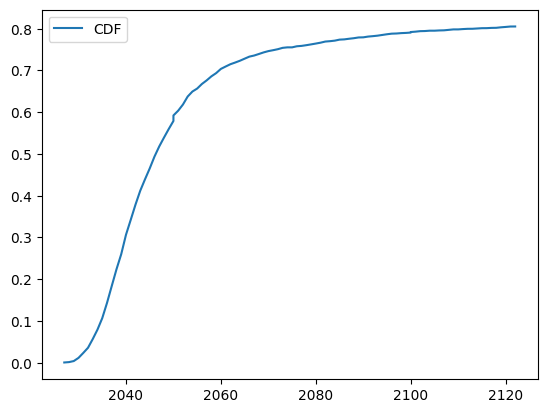

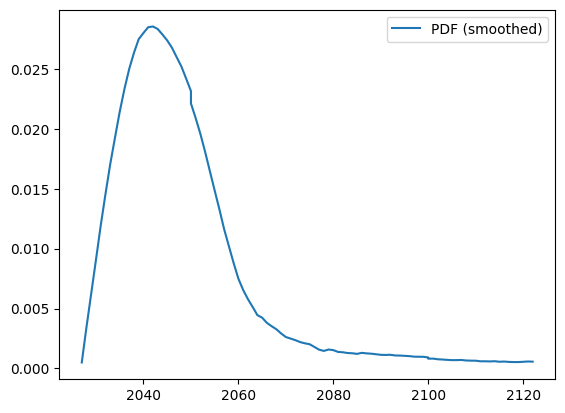

-
-
## TAI FLOP SIZE ##
{1: 23.0,
 5: 25.1,
 10: 25.8,
 20: 26.6,
 30: 27.6,
 40: 28.7,
 50: 30.4,
 60: 32.1,
 70: 33.9,
 80: 36.5,
 90: 39.9,
 95: 43.2,
 99: 49.9}
(Mean: 31.7)


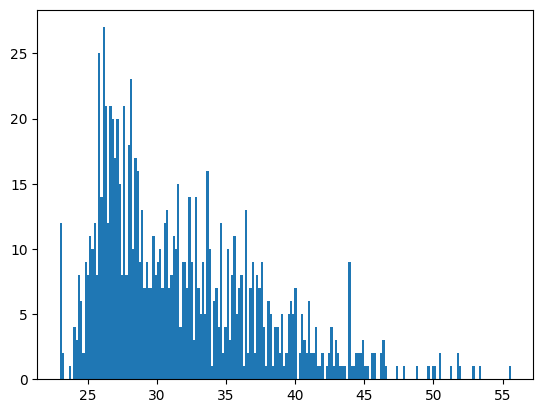

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.3,
 5: 14.5,
 10: 12.4,
 20: 9.8,
 30: 8.5,
 40: 7.5,
 50: 6.7,
 60: 5.9,
 70: 5.0,
 80: 4.4,
 90: 3.6,
 95: 3.1,
 99: 2.5}
(Mean: 7.4)


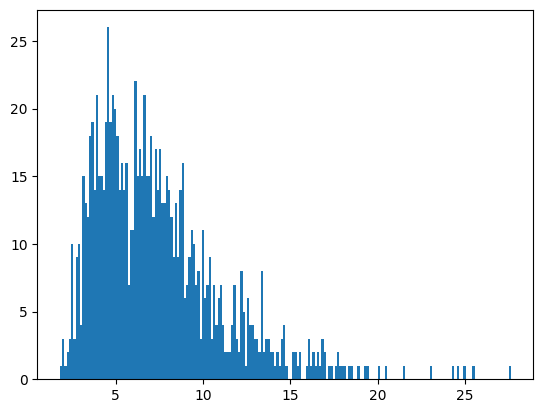

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.9,
 5: 3.5,
 10: 3.2,
 20: 3.0,
 30: 2.8,
 40: 2.7,
 50: 2.5,
 60: 2.3,
 70: 2.2,
 80: 2.0,
 90: 1.7,
 95: 1.5,
 99: 1.0}
(Mean: 2.5)


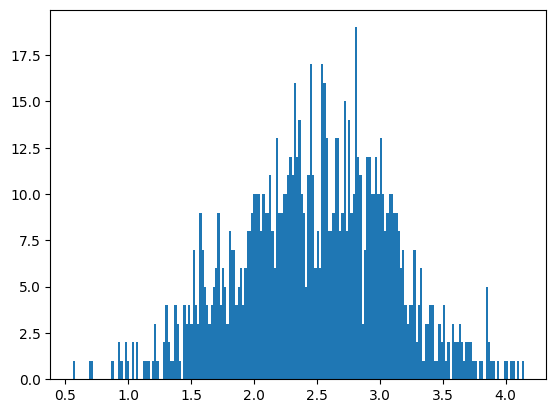

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.7,
 5: 21.0,
 10: 21.2,
 20: 21.5,
 30: 21.7,
 40: 21.8,
 50: 21.9,
 60: 22.1,
 70: 22.3,
 80: 22.5,
 90: 22.8,
 95: 23.0,
 99: 23.4}
(Mean: 22.0)


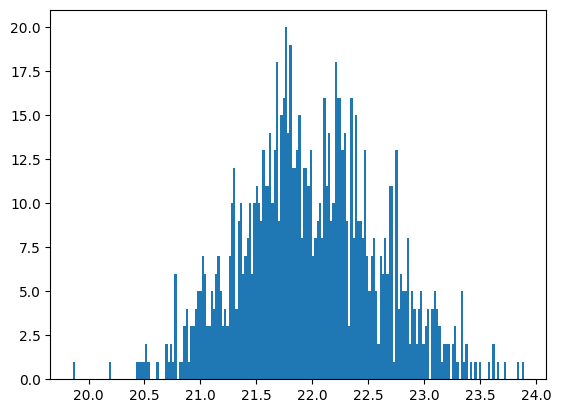

-
-
## INITIAL PAY ##
{1: 7.9,
 5: 8.1,
 10: 8.2,
 20: 8.4,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.3,
 99: 9.9}
(Mean: 8.6)


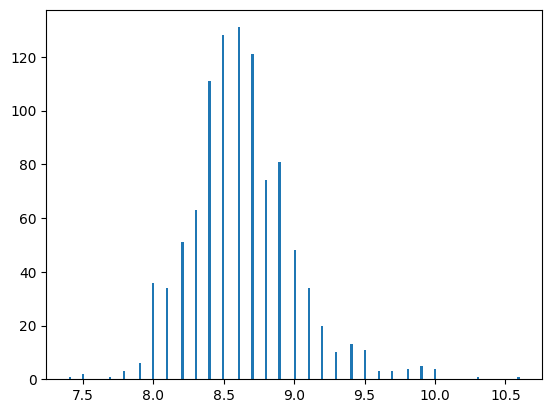

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


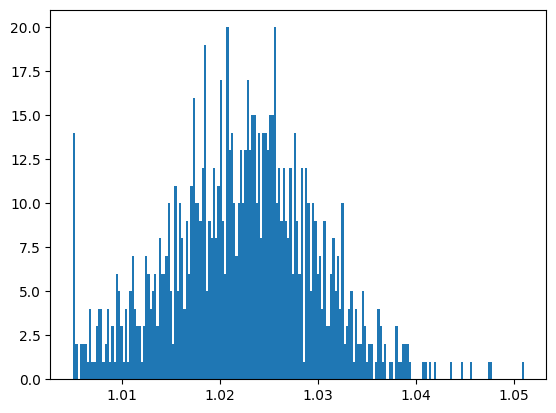

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.0003,
 50: 0.00039,
 60: 0.00052,
 70: 0.0007,
 80: 0.00109,
 90: 0.00249,
 95: 0.00416,
 99: 0.0115}
(Mean: 0.0)


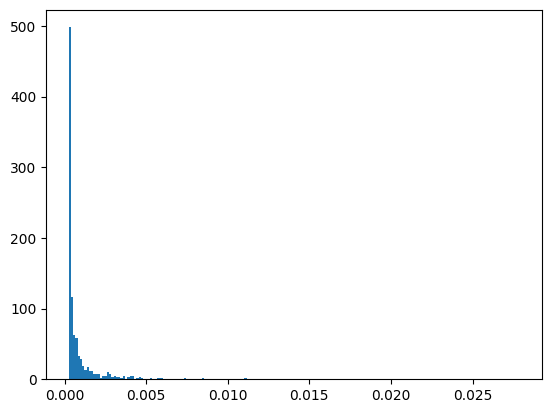

-
-
## SPEND DOUBLING TIME ##
{1: 5.1,
 5: 4.5,
 10: 4.1,
 20: 3.7,
 30: 3.4,
 40: 3.0,
 50: 2.8,
 60: 2.5,
 70: 2.3,
 80: 1.9,
 90: 1.5,
 95: 1.1,
 99: 0.9}
(Mean: 2.8)


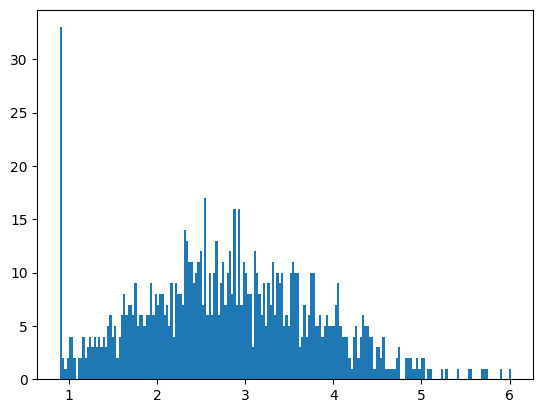

-
-
-
-
## GDP Over Time ##


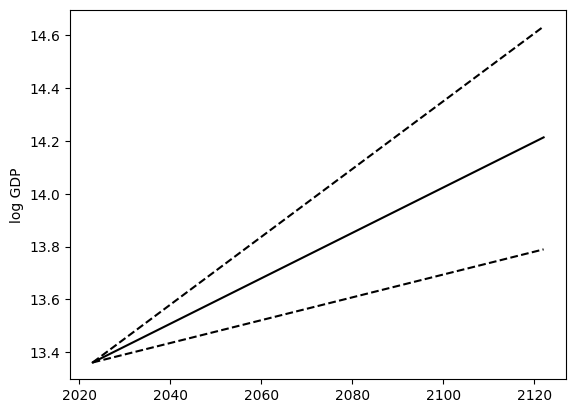

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

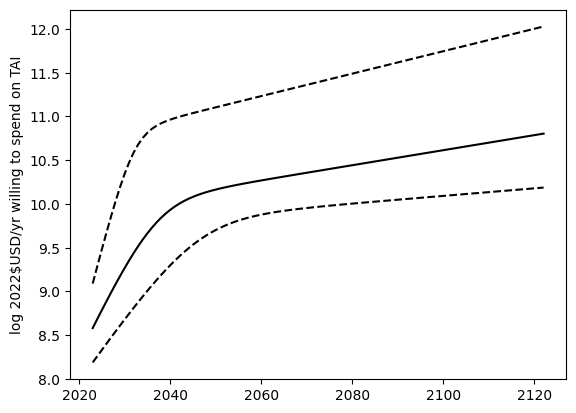

Year: 2023 - willingness log 2022$USD per year 8.6 (~381 million) 90% CI 8.2 (~154 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~483 million) 90% CI 8.3 (~182 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~610 million) 90% CI 8.3 (~214 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~769 million) 90% CI 8.4 (~252 million) - 9.7 (~5 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~965 million) 90% CI 8.5 (~296 million) - 9.9 (~7 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~348 million) - 10.0 (~11 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~1 billion) 90% CI 8.6 (~408 million) - 10.2 (~16 billion)
Year: 2030 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.7 (~477 million) - 10.3 (~22 billion)
Year: 2031 - willingness log 2022$USD per year 9.4 (~2 billion) 90% CI 8.7 (~558 million) - 10.5 (~30 billion)
Y

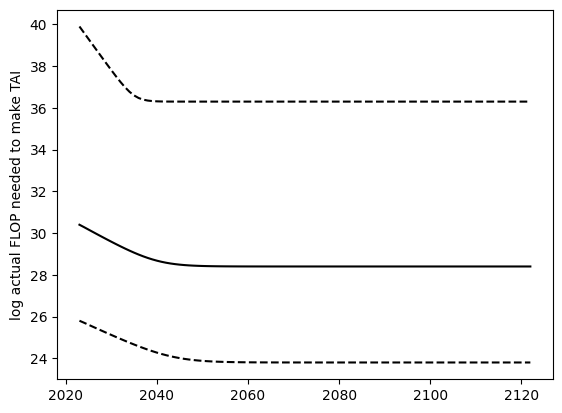

Year: 2023 - log FLOP needed for TAI 30.4 (~3 nonillion) 90% CI 25.8 (~63 septillion) - 39.9 (~8 million decillion)
Year: 2024 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 25.7 (~51 septillion) - 39.6 (~4 million decillion)
Year: 2025 - log FLOP needed for TAI 30.2 (~1 nonillion) 90% CI 25.6 (~40 septillion) - 39.3 (~2 million decillion)
Year: 2026 - log FLOP needed for TAI 30.0 (~1 nonillion) 90% CI 25.5 (~32 septillion) - 39.0 (~995 thousand decillion)
Year: 2027 - log FLOP needed for TAI 29.9 (~854 octillion) 90% CI 25.4 (~26 septillion) - 38.7 (~498 thousand decillion)
Year: 2028 - log FLOP needed for TAI 29.8 (~653 octillion) 90% CI 25.3 (~21 septillion) - 38.4 (~250 thousand decillion)
Year: 2029 - log FLOP needed for TAI 29.7 (~501 octillion) 90% CI 25.2 (~16 septillion) - 38.1 (~126 thousand decillion)
Year: 2030 - log FLOP needed for TAI 29.6 (~386 octillion) 90% CI 25.1 (~13 septillion) - 37.8 (~64 thousand decillion)
Year: 2031 - log FLOP needed for TAI 29.5 (~298 oc

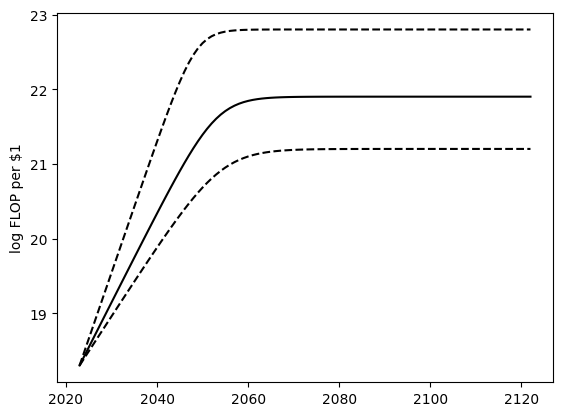

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.7 (~5 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~7 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~10 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.2 (~15 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~7 quintillion) - 19.4 (~23 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~9 quintillion) - 19.5 (~35 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.7 (~52 quint

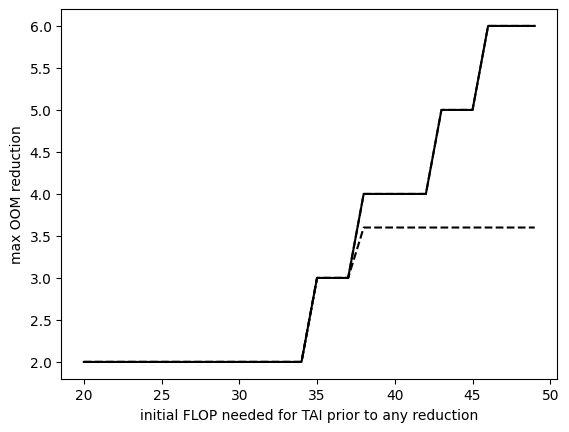

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

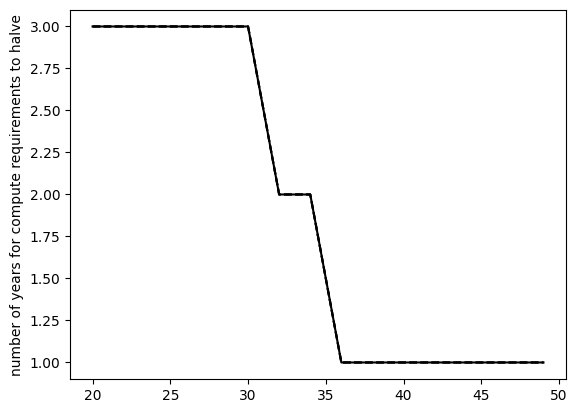

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

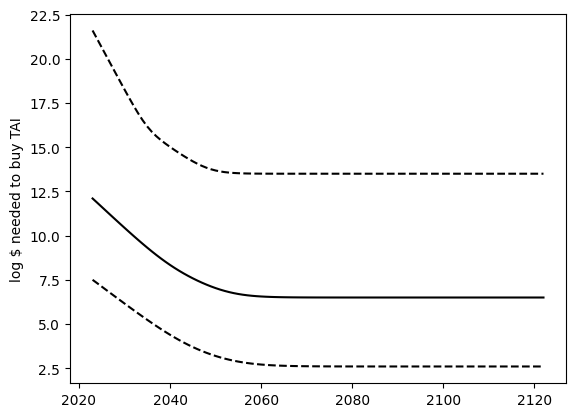

Year: 2023 - 12.1 log 2022$USD to buy TAI (~1 trillion) 90% CI 7.5 (~32 million) - 21.6 (~4 sextillion)
Year: 2024 - 11.9 log 2022$USD to buy TAI (~733 billion) 90% CI 7.3 (~20 million) - 21.1 (~1 sextillion)
Year: 2025 - 11.6 log 2022$USD to buy TAI (~423 billion) 90% CI 7.1 (~13 million) - 20.6 (~441 quintillion)
Year: 2026 - 11.4 log 2022$USD to buy TAI (~244 billion) 90% CI 6.9 (~8 million) - 20.2 (~147 quintillion)
Year: 2027 - 11.2 log 2022$USD to buy TAI (~141 billion) 90% CI 6.7 (~5 million) - 19.7 (~49 quintillion)
Year: 2028 - 10.9 log 2022$USD to buy TAI (~82 billion) 90% CI 6.5 (~3 million) - 19.2 (~16 quintillion)
Year: 2029 - 10.7 log 2022$USD to buy TAI (~48 billion) 90% CI 6.4 (~2 million) - 18.7 (~5 quintillion)
Year: 2030 - 10.4 log 2022$USD to buy TAI (~28 billion) 90% CI 6.2 (~1 million) - 18.3 (~2 quintillion)
Year: 2031 - 10.2 log 2022$USD to buy TAI (~16 billion) 90% CI 6.0 (~943 thousand) - 17.8 (~635 quadrillion)
Year: 2032 - 10.0 log 2022$USD to buy TAI (~10 b

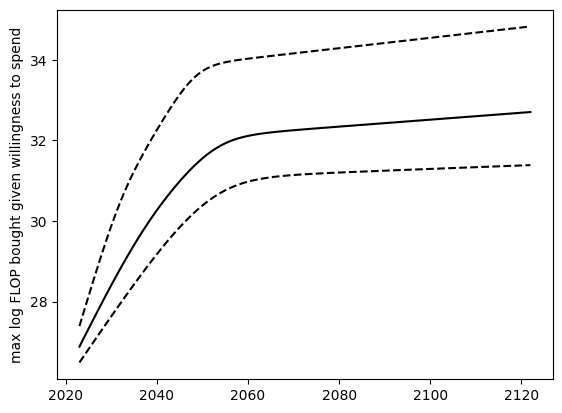

Year: 2023 - max log FLOP 26.9 (~760 septillion) 90% CI 26.5 (~307 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 27.1 (~1 octillion) 90% CI 26.7 (~450 septillion) - 27.8 (~6 octillion)
Year: 2025 - max log FLOP 27.3 (~2 octillion) 90% CI 26.8 (~658 septillion) - 28.1 (~14 octillion)
Year: 2026 - max log FLOP 27.5 (~4 octillion) 90% CI 27.0 (~961 septillion) - 28.5 (~32 octillion)
Year: 2027 - max log FLOP 27.8 (~6 octillion) 90% CI 27.1 (~1 octillion) - 28.9 (~72 octillion)
Year: 2028 - max log FLOP 28.0 (~10 octillion) 90% CI 27.3 (~2 octillion) - 29.2 (~163 octillion)
Year: 2029 - max log FLOP 28.2 (~16 octillion) 90% CI 27.5 (~3 octillion) - 29.6 (~358 octillion)
Year: 2030 - max log FLOP 28.4 (~26 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~761 octillion)
Year: 2031 - max log FLOP 28.6 (~41 octillion) 90% CI 27.8 (~6 octillion) - 30.2 (~2 nonillion)
Year: 2032 - max log FLOP 28.8 (~66 octillion) 90% CI 28.0 (~9 octillion) - 30.5 (~3 nonillion)
Year: 2033 - max log 

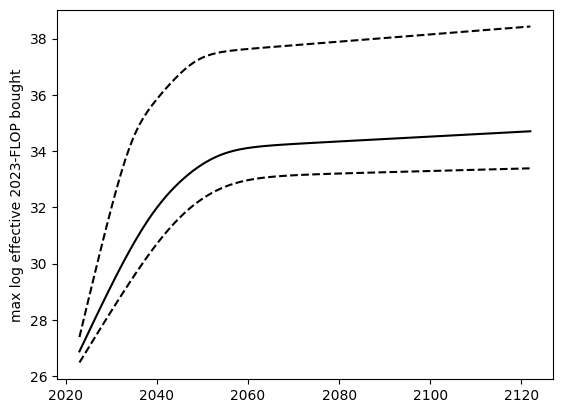

Year: 2023 - max log effective 2023-FLOP 26.9 (~760 septillion) 90% CI 26.5 (~307 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.7 (~560 septillion) - 28.1 (~12 octillion)
Year: 2025 - max log effective 2023-FLOP 27.6 (~4 octillion) 90% CI 27.0 (~1 octillion) - 28.7 (~54 octillion)
Year: 2026 - max log effective 2023-FLOP 27.9 (~8 octillion) 90% CI 27.3 (~2 octillion) - 29.4 (~252 octillion)
Year: 2027 - max log effective 2023-FLOP 28.2 (~17 octillion) 90% CI 27.5 (~3 octillion) - 30.1 (~1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.6 (~37 octillion) 90% CI 27.8 (~6 octillion) - 30.7 (~5 nonillion)
Year: 2029 - max log effective 2023-FLOP 28.9 (~79 octillion) 90% CI 28.1 (~11 octillion) - 31.4 (~23 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.2 (~167 octillion) 90% CI 28.3 (~21 octillion) - 32.0 (~94 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.5 (~348 octillion) 90% CI 28.6 (~37 octillion) - 32.6 

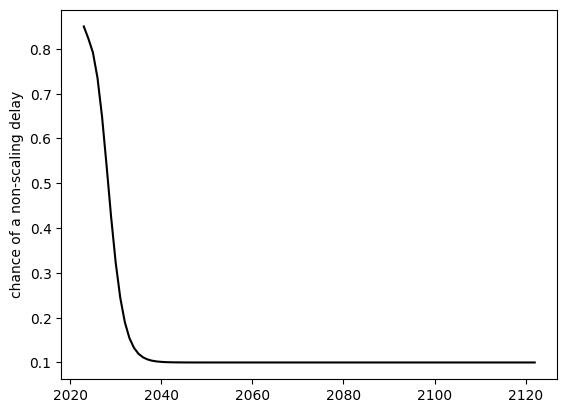

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 82%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 65%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

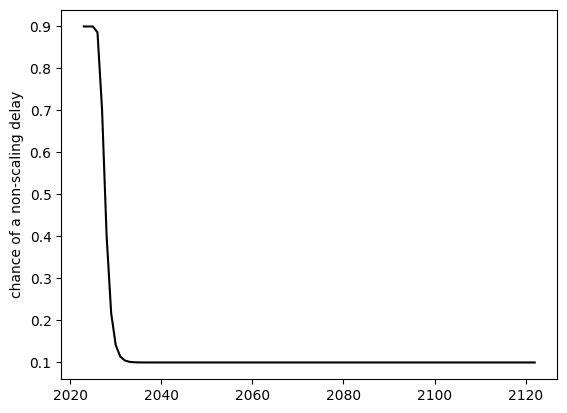

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

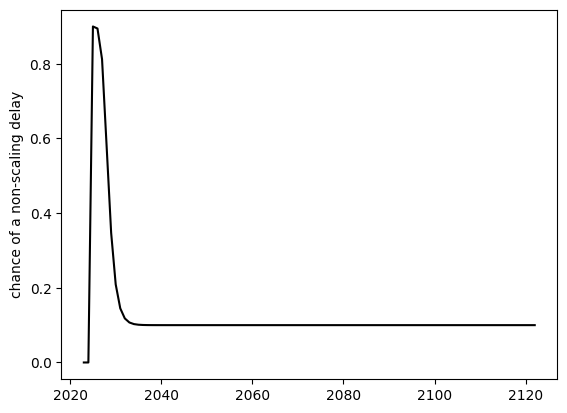

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 81%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2033 -

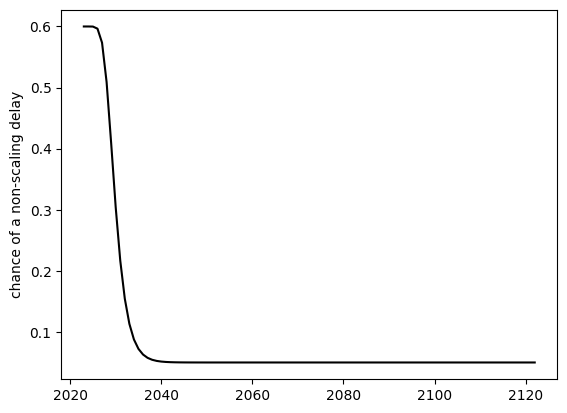

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2033

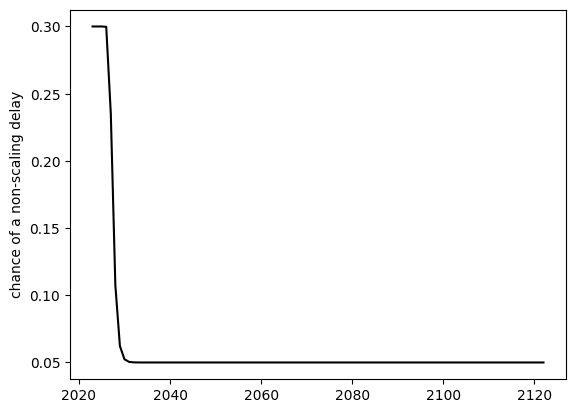

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - c

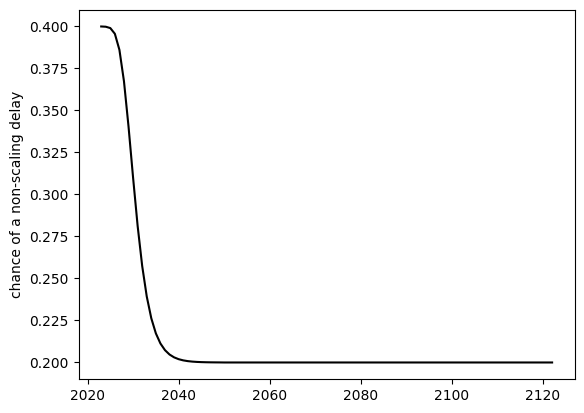

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2033

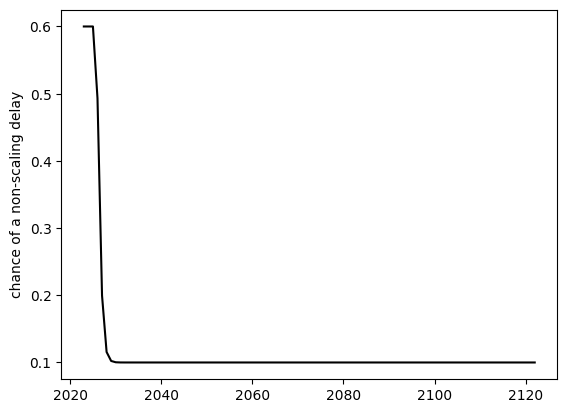

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

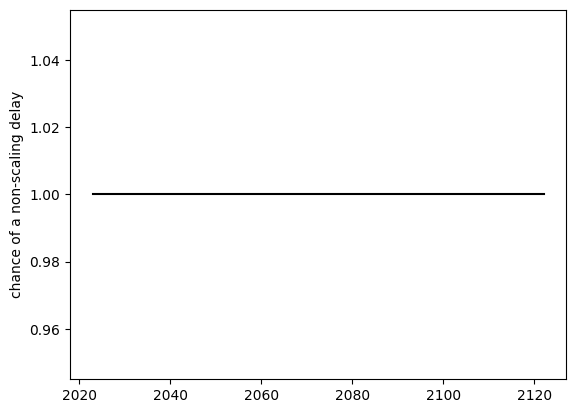

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


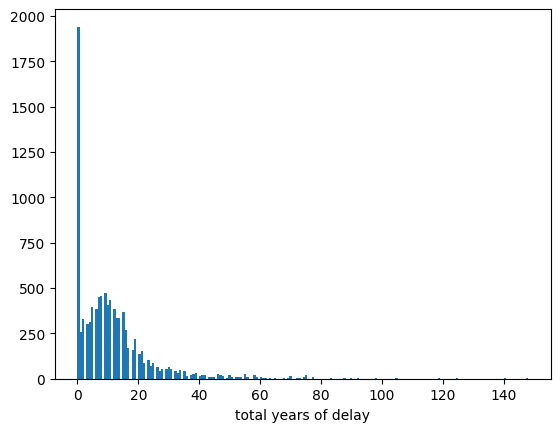

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 50.1 log FLOP (~126 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 7 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.2 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 2.7 years to a max of 0.107858% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.7 max log FLOP (491 septillion) available - TAI takes 50.1 log FLOP (126 quadrillion decillion) - log $ 31.8 to buy TAI (63 nonillion) vs. willingness to pay log $ 8.4 (246 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 49.8 log FLOP (63 quadrillion decillion) - log $ 31.2 to buy TAI (18 nonillion) vs. willingness to pay log $ 8.5 (317 million) - 18.5 log FLOP per $ (4

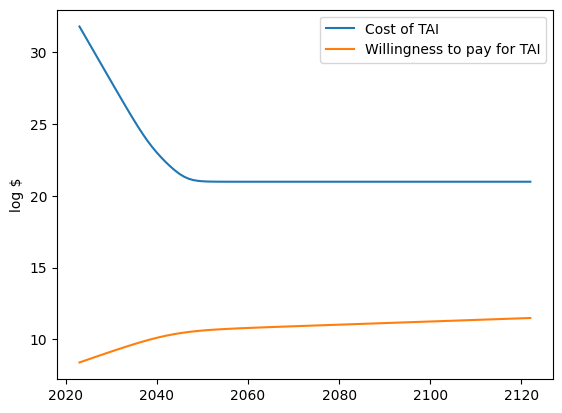

-
-
## SAMPLE RUN 5 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.9 to buy TAI (807 million) vs. willingness to pay log $ 8.7 (449 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.1)
Year:

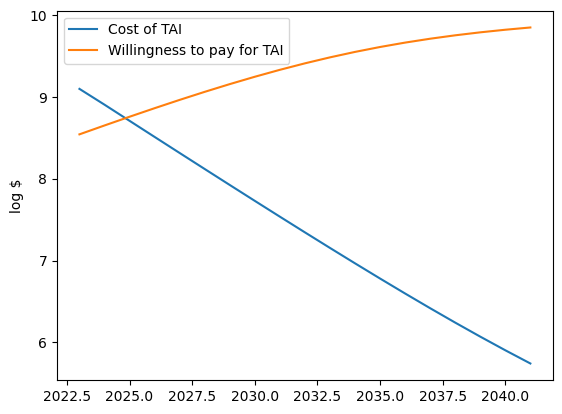

-
-
## SAMPLE RUN 6 ##
It takes 34.5 log FLOP (~32 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~790 million). This doubles every 2.9 years to a max of 0.610643% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 34.5 log FLOP (32 decillion) - log $ 16.2 to buy TAI (16 quadrillion) vs. willingness to pay log $ 8.9 (785 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 34.3 log FLOP (20 decillion) - log $ 15.9 to buy TAI (8 quadrillion) vs. willingness to pay log $ 9.0 (999 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

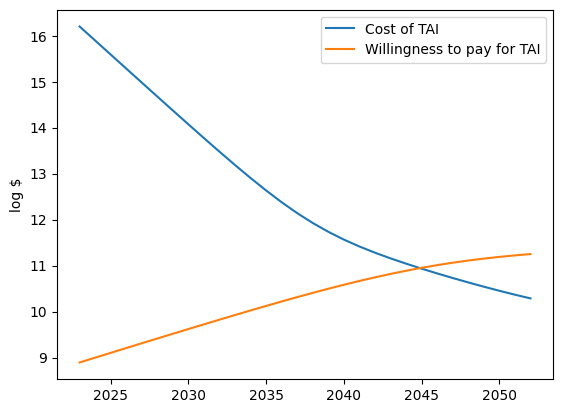

-
-
## SAMPLE RUN 7 ##
It takes 40.4 log FLOP (~25 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 4.9 years to a max of 0.076871% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.7 max log FLOP (487 septillion) available - TAI takes 40.4 log FLOP (25 million decillion) - log $ 22.1 to buy TAI (13 sextillion) vs. willingness to pay log $ 8.4 (244 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (775 septillion) available - TAI takes 40.1 log FLOP (13 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 8.4 (281 million) - 18.4 log FLOP per $ (3 quintilli

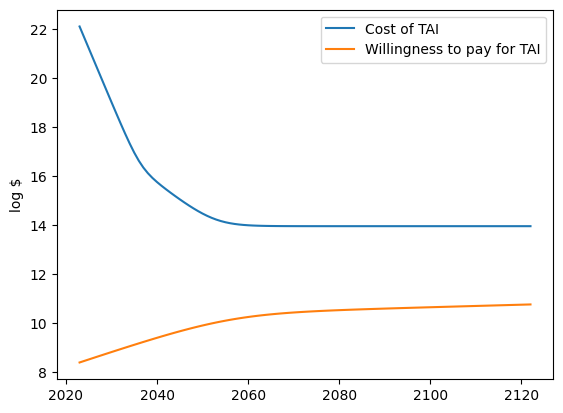

-
-
## SAMPLE RUN 8 ##
It takes 29.4 log FLOP (~251 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.6 years to a max of 0.071733% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.4 max log FLOP (247 septillion) available - TAI takes 29.4 log FLOP (251 octillion) - log $ 11.1 to buy TAI (126 billion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (412 septillion) available - TAI takes 29.3 log FLOP (202 octillion) - log $ 10.9 to buy TAI (73 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

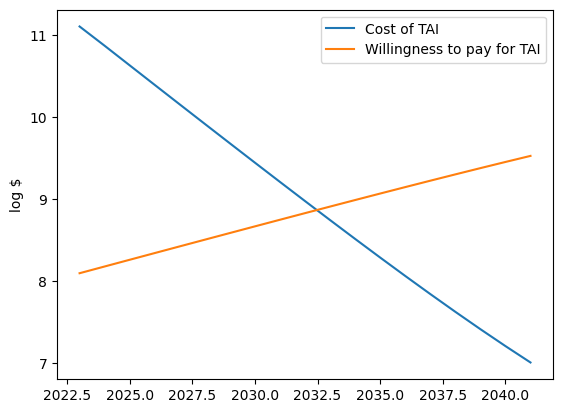

-
-
## SAMPLE RUN 9 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 2.1 years to a max of 0.077095% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.7 max log FLOP (487 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 8.4 (244 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP (942 septillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (875 billion) vs. willingness to pay log $ 8.5 (340 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

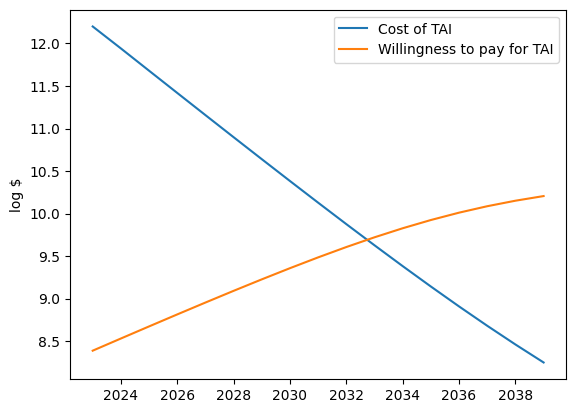

-
-
## SAMPLE RUN 10 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~122 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 2.8 years to a max of 0.056143% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.7 max log FLOP (482 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.4 (242 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (773 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (640 million) vs. willingness to pay log $ 8.5 (308 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

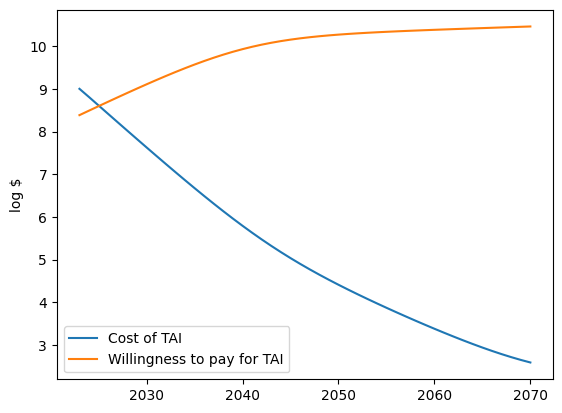

-
-
## SAMPLE RUN 11 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~201 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 2.4 years to a max of 0.078483% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.6 max log FLOP (389 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.3 (195 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (733 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (570 million) vs. willingness to pay log $ 8.4 (260 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

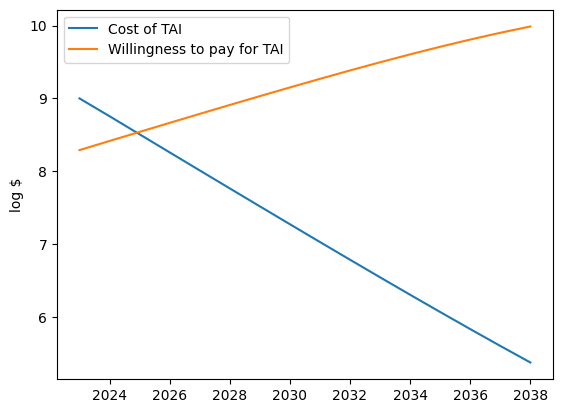

-
-
## SAMPLE RUN 12 ##
It takes 35.6 log FLOP (~398 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~244 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.039847% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.7 max log FLOP (475 septillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.3 to buy TAI (200 quadrillion) vs. willingness to pay log $ 8.4 (238 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 16.9 to buy TAI (87 quadrillion) vs. willingness to pay log $ 8.7 (462 million) - 18.5 l

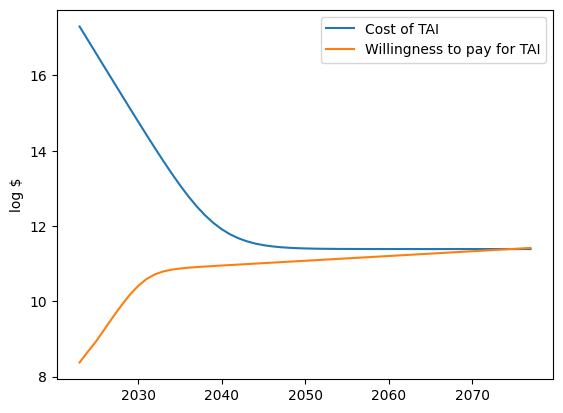

-
-
## SAMPLE RUN 13 ##
It takes 29.4 log FLOP (~251 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~583 million). This doubles every 2.8 years to a max of 0.032984% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 29.4 log FLOP (251 octillion) - log $ 11.1 to buy TAI (126 billion) vs. willingness to pay log $ 8.7 (541 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 29.3 log FLOP (202 octillion) - log $ 10.9 to buy TAI (78 billion) vs. willingness to pay log $ 8.8 (679 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

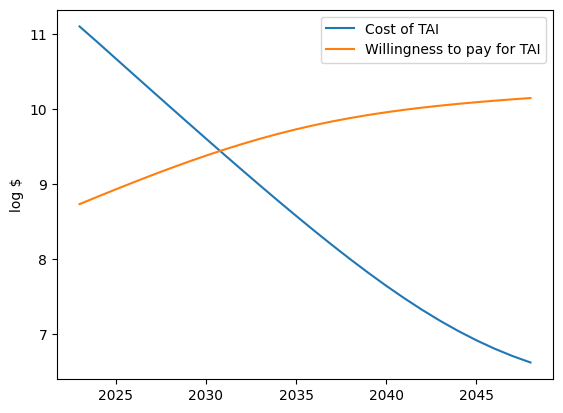

-
-
## SAMPLE RUN 14 ##
It takes 31.5 log FLOP (~32 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~958 quintillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~463 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.026134% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.9 max log FLOP (855 septillion) available - TAI takes 31.5 log FLOP (32 nonillion) - log $ 13.2 to buy TAI (16 trillion) vs. willingness to pay log $ 8.6 (430 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 31.4 log FLOP (24 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 8.9 (804 million) - 18.4 log FLO

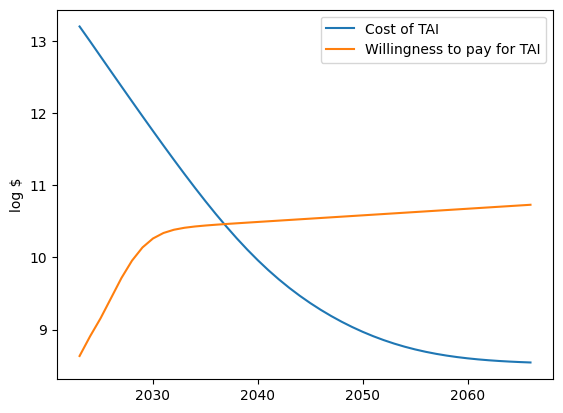

-
-
## SAMPLE RUN 15 ##
It takes 42.2 log FLOP (~2 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.1 years to a max of 0.062182% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 42.2 log FLOP (2 billion decillion) - log $ 23.9 to buy TAI (794 sextillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.6 max log FLOP (358 septillion) available - TAI takes 41.9 log FLOP (803 million decillion) - log $ 23.5 to buy TAI (309 sextillion) vs. willingness to pay log $ 8.1 (138 million) - 18.4 log FLOP per $ (3 quinti

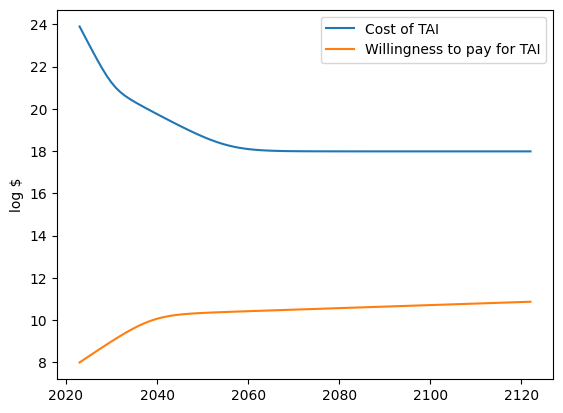

-
-
## SAMPLE RUN 16 ##
It takes 41.8 log FLOP (~631 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~11 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 41.8 log FLOP (631 million decillion) - log $ 23.5 to buy TAI (316 sextillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.4 max log FLOP (280 septillion) available - TAI takes 41.5 log FLOP (316 million decillion) - log $ 23.1 to buy TAI (131 sextillion) vs. willingness to pay log $ 8.1 (116 million) - 18.4 log FLOP per $ (2 quintill

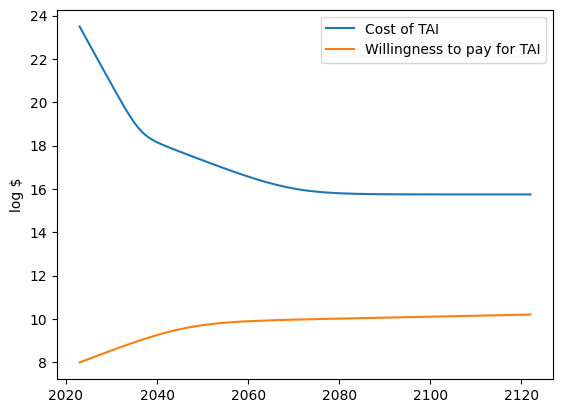

-
-
## SAMPLE RUN 17 ##
It takes 25.3 log FLOP (~20 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~301 million). This doubles every 5.9 years to a max of 0.026384% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (571 septillion) available - TAI takes 25.3 log FLOP (20 septillion) - log $ 7.0 to buy TAI (10 million) vs. willingness to pay log $ 8.5 (286 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 8 years)
-- data p_nons

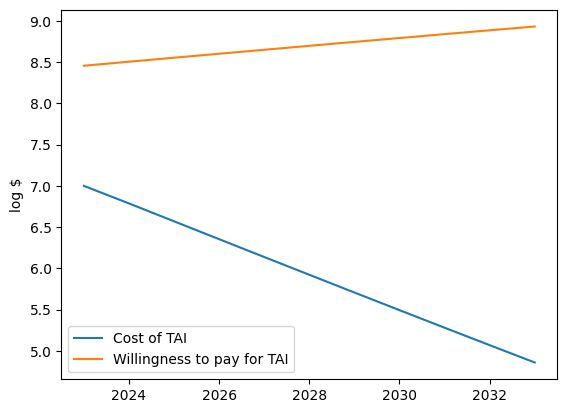

-
-
## SAMPLE RUN 18 ##
It takes 32.2 log FLOP (~158 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~79 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~491 million). This doubles every 2.8 years to a max of 0.103317% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.0 max log FLOP (960 septillion) available - TAI takes 32.2 log FLOP (158 nonillion) - log $ 13.9 to buy TAI (79 trillion) vs. willingness to pay log $ 8.7 (481 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 32.1 log FLOP (114 nonillion) - log $ 13.7 to buy TAI (46 trillion) vs. willingness to pay log $ 8.8 (612 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logF

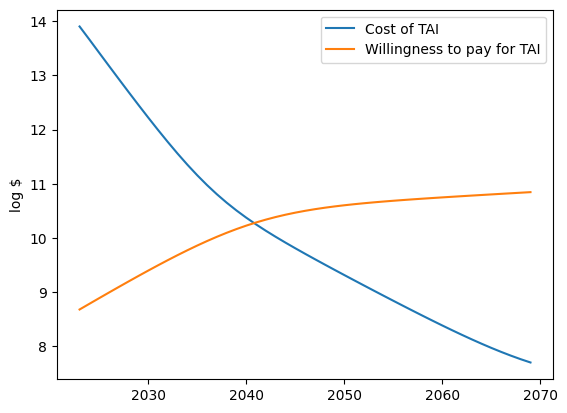

-
-
## SAMPLE RUN 19 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~461 quintillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~397 million). This doubles every 3.7 years to a max of 0.87948% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.9 max log FLOP (788 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.6 (397 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.7 (477 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

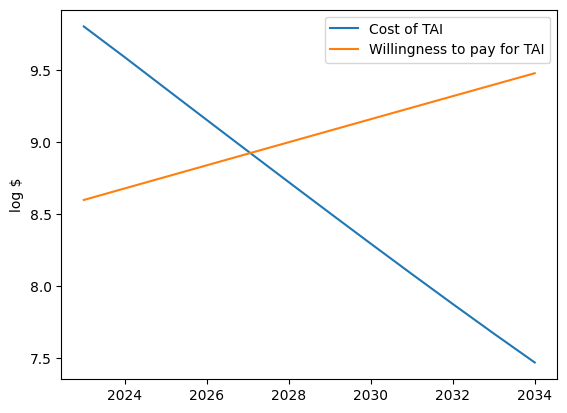

-
-
## SAMPLE RUN 20 ##
It takes 25.9 log FLOP (~79 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~700 million). This doubles every 2.7 years to a max of 0.025549% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 25.9 log FLOP (79 septillion) - log $ 7.6 to buy TAI (40 million) vs. willingness to pay log $ 8.8 (625 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not o

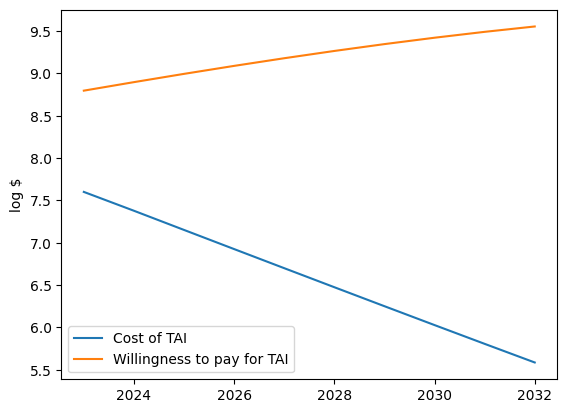

-
-
## SAMPLE RUN 21 ##
It takes 25.0 log FLOP (~10 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~3 billion). This doubles every 5.0 years to a max of 0.038921% of GDP. GDP grows at a rate of 1.04x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 25.0 log FLOP (10 septillion) - log $ 6.7 to buy TAI (5 million) vs. willingness to pay log $ 9.3 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-

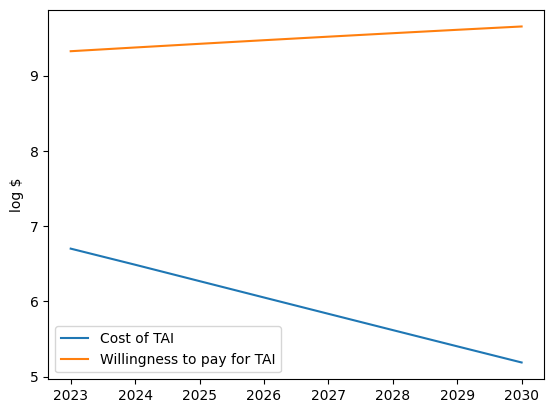

-
-
## SAMPLE RUN 22 ##
It takes 29.6 log FLOP (~398 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 29.6 log FLOP (398 octillion) - log $ 11.3 to buy TAI (200 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 29.5 log FLOP (320 octillion) - log $ 11.0 to buy TAI (97 billion) vs. willingness to pay log $ 8.7 (468 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP:

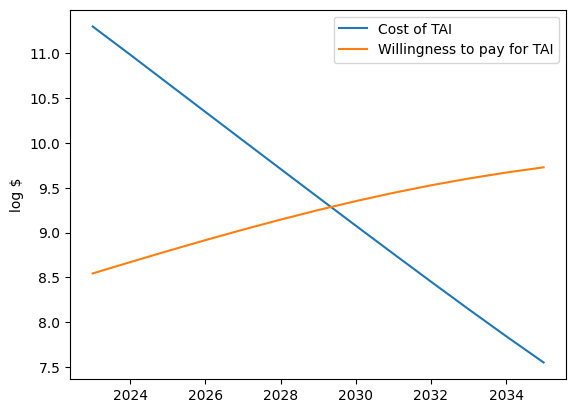

-
-
## SAMPLE RUN 23 ##
It takes 26.3 log FLOP (~200 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 3.8 years to a max of 0.072383% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 26.5 max log FLOP (310 septillion) available - TAI takes 26.3 log FLOP (200 septillion) - log $ 8.0 to buy TAI (100 million) vs. willingness to pay log $ 8.2 (156 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_n

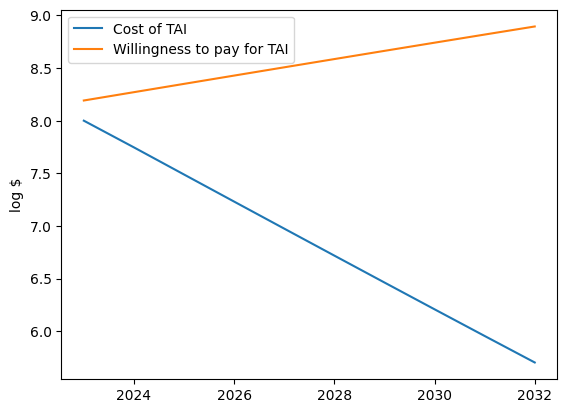

-
-
## SAMPLE RUN 24 ##
It takes 52.1 log FLOP (~13 quintillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 7.0 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 4.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 52.1 log FLOP (13 quintillion decillion) - log $ 33.8 to buy TAI (6 decillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 51.8 log FLOP (6 quintillion decillion) - log $ 33.4 to buy TAI (3 decillion) vs. willingness to pay log $ 8.9 (711 million) - 18.4 log FLOP per $ (3 quintill

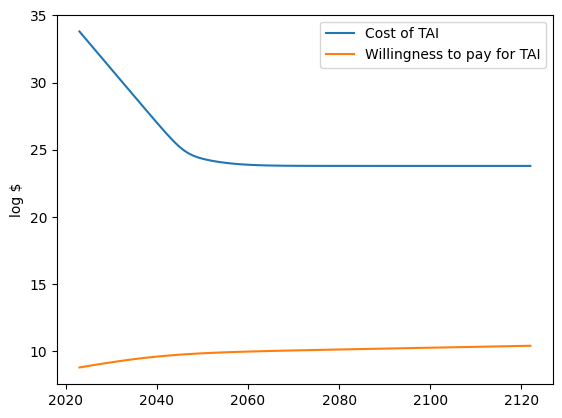

-
-
## SAMPLE RUN 25 ##
It takes 31.2 log FLOP (~16 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~310 million). This doubles every 1.5 years to a max of 0.067818% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.8 max log FLOP (606 septillion) available - TAI takes 31.2 log FLOP (16 nonillion) - log $ 12.9 to buy TAI (8 trillion) vs. willingness to pay log $ 8.5 (304 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 31.1 log FLOP (12 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.7 (473 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

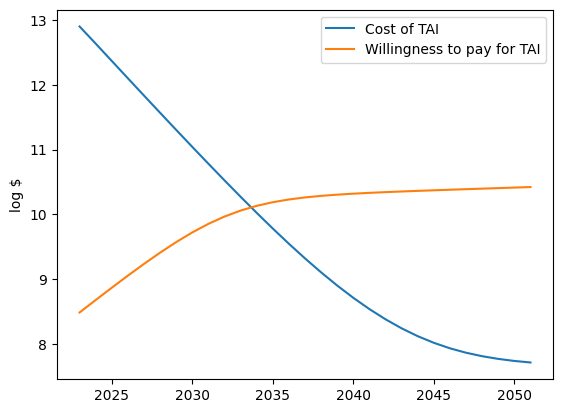

-
-
## SAMPLE RUN 26 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.6 years to a max of 0.026129% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.9 (887 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not o

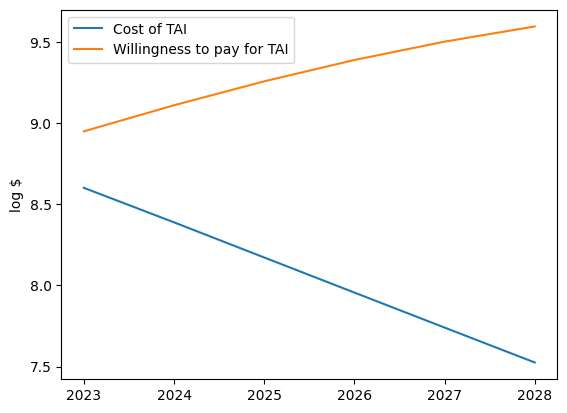

-
-
## SAMPLE RUN 27 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 2.6 years to a max of 0.027622% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (253 quadrillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (2 quintillion) (Effect

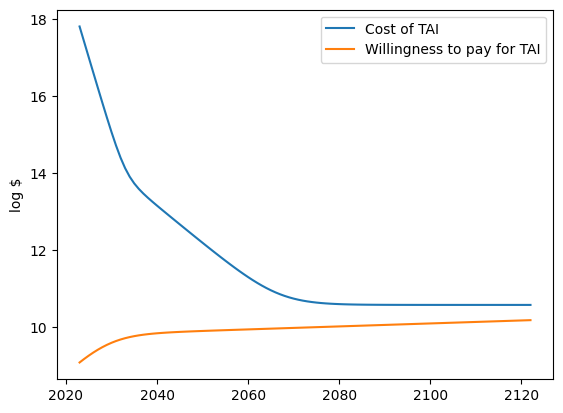

-
-
## SAMPLE RUN 28 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~29 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.1 years to a max of 0.049808% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.4 to buy TAI (251 trillion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.0)
Year: 2024 - 26.2 max log FLOP (171 septillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 14.1 to buy TAI (131 trillion) vs. willingness to pay log $ 7.8 (62 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

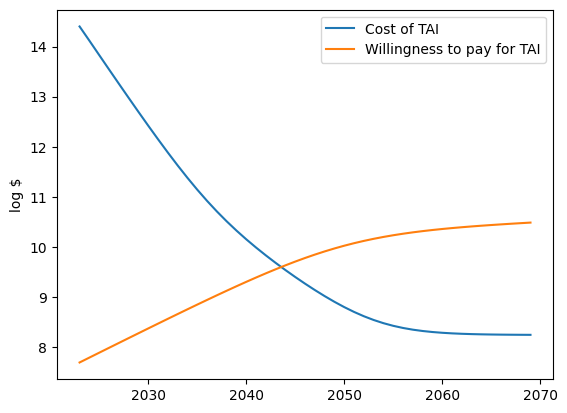

-
-
## SAMPLE RUN 29 ##
It takes 48.2 log FLOP (~2 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~728 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.038156% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 48.2 log FLOP (2 quadrillion decillion) - log $ 29.9 to buy TAI (795 octillion) vs. willingness to pay log $ 8.8 (673 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 47.9 log FLOP (793 trillion decillion) - log $ 29.5 to buy TAI (302 octillion) vs. willingness to pay log $ 9.

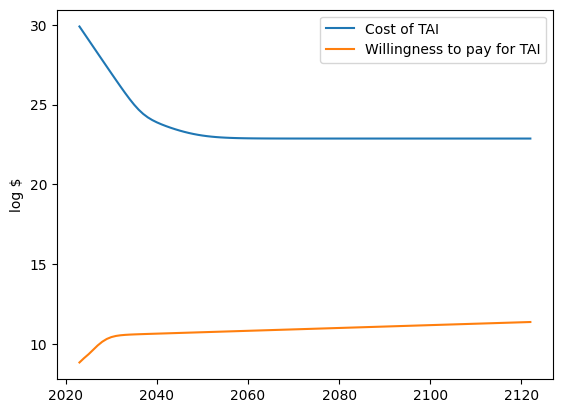

-
-
## SAMPLE RUN 30 ##
It takes 31.3 log FLOP (~20 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~245 million). This doubles every 1.1 years to a max of 0.044318% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.7 max log FLOP (477 septillion) available - TAI takes 31.3 log FLOP (20 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 8.4 (239 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 31.2 log FLOP (15 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.6 (435 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

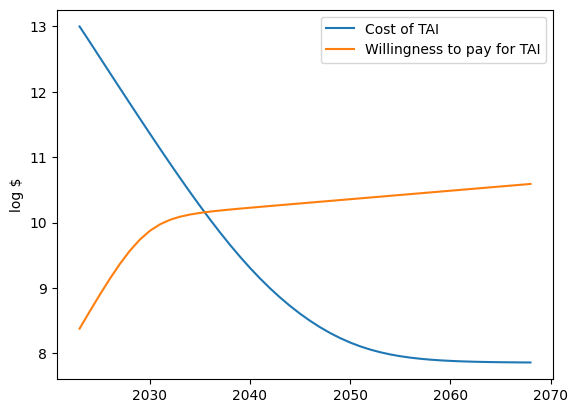

-
-
## SAMPLE RUN 31 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.3 to buy TAI (218 million) vs. willingness to pay log $ 8.6 (383 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

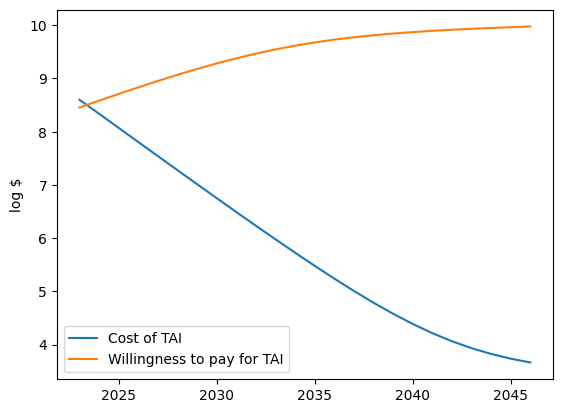

-
-
## SAMPLE RUN 32 ##
It takes 27.8 log FLOP (~6 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 1.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.6 max log FLOP (441 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.2 (158 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 

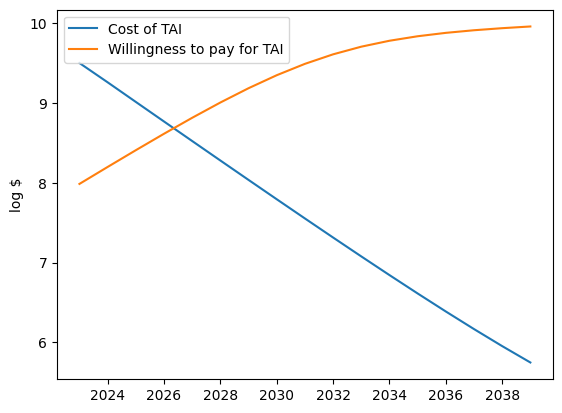

-
-
## SAMPLE RUN 33 ##
It takes 30.0 log FLOP (~1 nonillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 1.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 30.0 log FLOP (1 nonillion) - log $ 11.7 to buy TAI (501 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.9 log FLOP (804 octillion) - log $ 11.5 to buy TAI (297 billion) vs. willingness to pay log $ 8.7 (511 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27

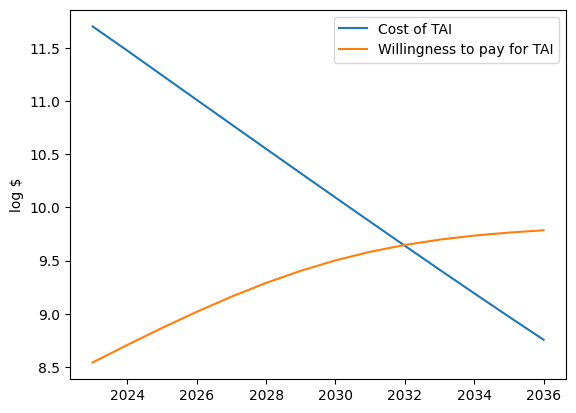

-
-
## SAMPLE RUN 34 ##
It takes 28.4 log FLOP (~25 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.1 to buy TAI (13 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.9 max log FLOP (713 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.5 (295 million) - 18.4 log FLOP per $ 

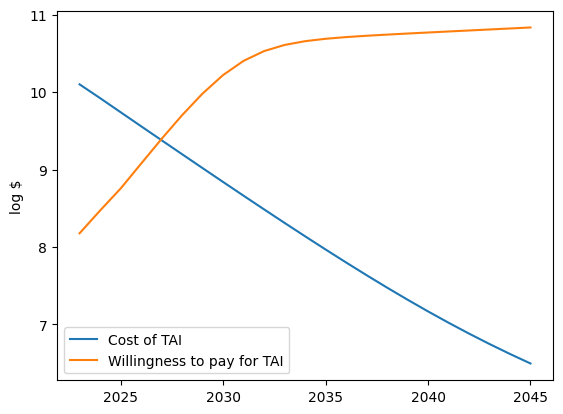

-
-
## SAMPLE RUN 35 ##
It takes 43.4 log FLOP (~25 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~769 quintillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 3.1 years to a max of 0.080675% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.6 max log FLOP (389 septillion) available - TAI takes 43.4 log FLOP (25 billion decillion) - log $ 25.1 to buy TAI (13 septillion) vs. willingness to pay log $ 8.3 (195 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (651 septillion) available - TAI takes 43.1 log FLOP (13 billion decillion) - log $ 24.7 to buy TAI (5 septillion) vs. willingness to pay log $ 8.4 (243 million) - 18.4 log FLOP per $ (3 quinti

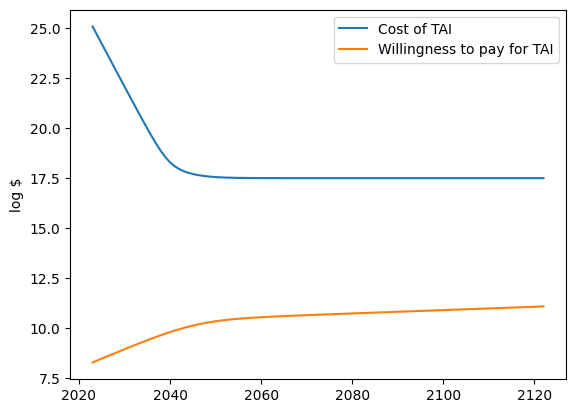

-
-
## SAMPLE RUN 36 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~257 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 5.4 years to a max of 0.132444% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.3 max log FLOP (198 septillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (306 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (711 billion) vs. willingness to pay log $ 8.1 (113 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP:

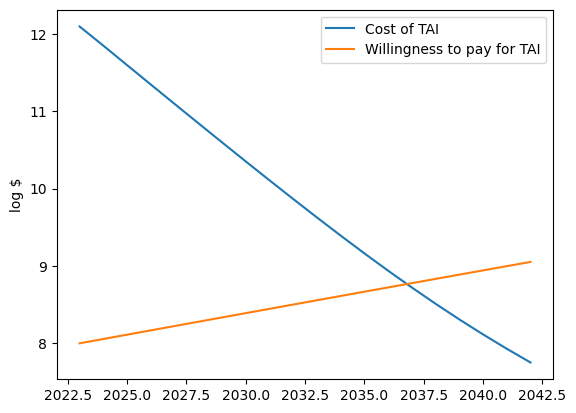

-
-
## SAMPLE RUN 37 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.9 (786 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

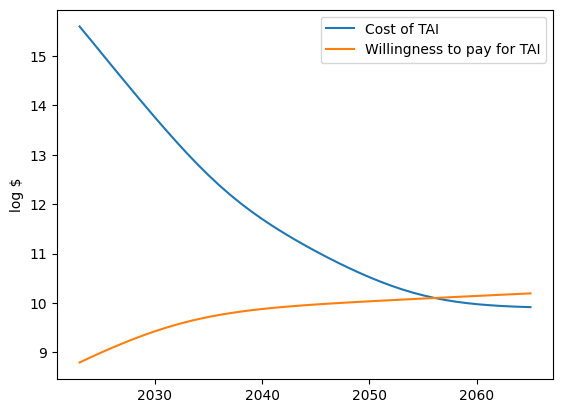

-
-
## SAMPLE RUN 38 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (79 million) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 5 years)
-- data p_nonsca

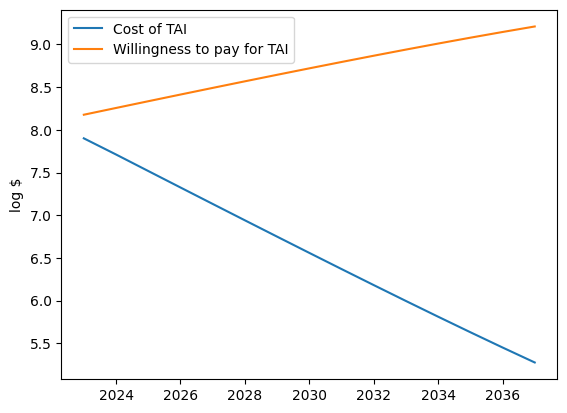

-
-
## SAMPLE RUN 39 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 1.4 years to a max of 0.300307% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.8 max log FLOP (625 septillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.5 to buy TAI (316 quintillion) vs. willingness to pay log $ 8.5 (313 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.1 to buy TAI (117 quintillion) vs. willingness to pay log $ 8.7 (521 million) - 18.4 log FLOP per $ (3 q

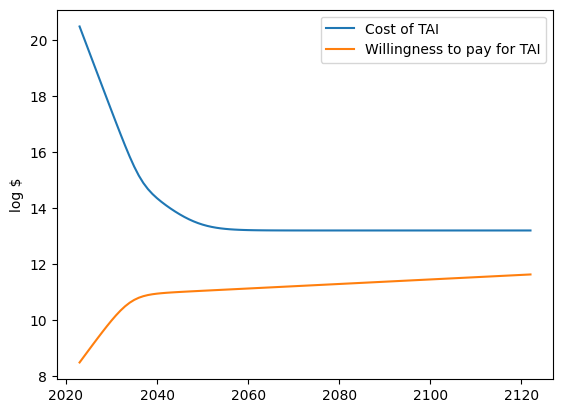

-
-
## SAMPLE RUN 40 ##
It takes 30.0 log FLOP (~1 nonillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 4.7 years to a max of 0.116777% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.4 max log FLOP (249 septillion) available - TAI takes 30.0 log FLOP (1 nonillion) - log $ 11.7 to buy TAI (501 billion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (405 septillion) available - TAI takes 29.9 log FLOP (804 octillion) - log $ 11.5 to buy TAI (286 billion) vs. willingness to pay log $ 8.2 (144 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

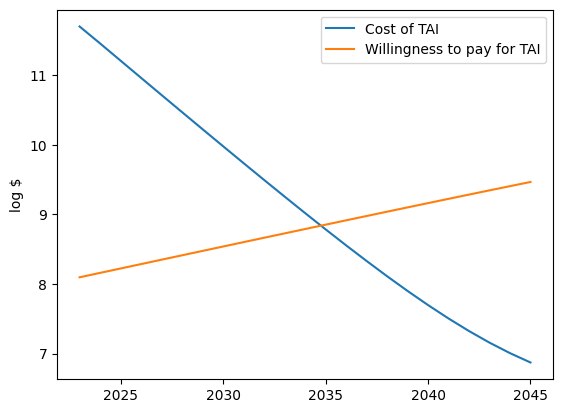

-
-
## SAMPLE RUN 41 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~247 million). This doubles every 2.9 years to a max of 0.063684% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.7 max log FLOP (484 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.4 (243 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (813 septillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.5 (308 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

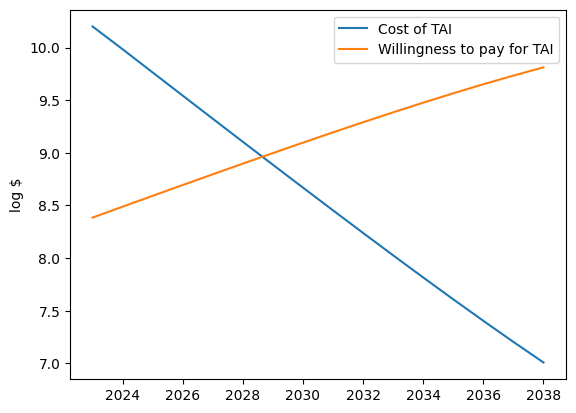

-
-
## SAMPLE RUN 42 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (232 quadrillion) vs. willingness to pay log $ 8.7 (458 million) - 18.4 log FLOP per $ (3 quintillion) (E

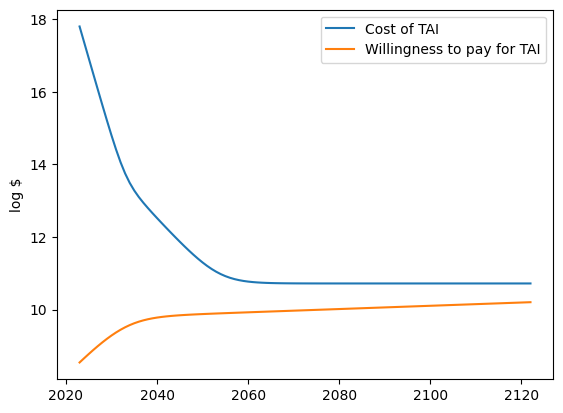

-
-
## SAMPLE RUN 43 ##
It takes 25.3 log FLOP (~20 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~58 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~382 million). This doubles every 3.7 years to a max of 0.041932% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.9 max log FLOP (734 septillion) available - TAI takes 25.3 log FLOP (20 septillion) - log $ 7.0 to buy TAI (10 million) vs. willingness to pay log $ 8.6 (368 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did n

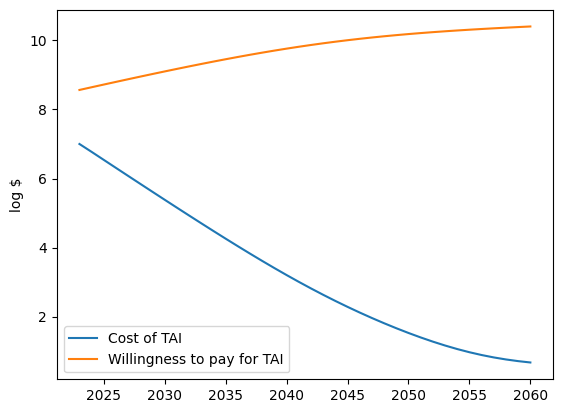

-
-
## SAMPLE RUN 44 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.3 years to a max of 0.0272% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.7 max log FLOP (464 septillion) available - TAI takes 25.6 log FLOP (40 septillion) - log $ 7.3 to buy TAI (20 million) vs. willingness to pay log $ 8.4 (233 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 4 years)
-- data p_nonscal

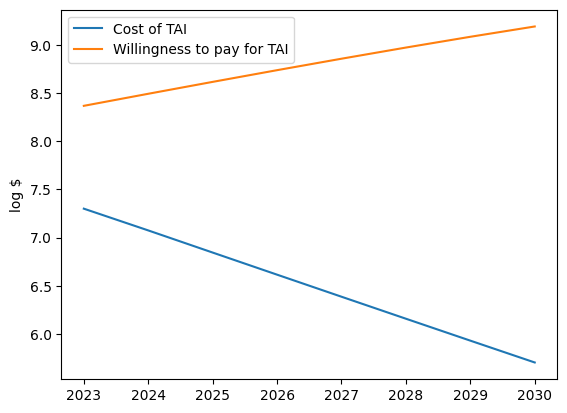

-
-
## SAMPLE RUN 45 ##
It takes 37.6 log FLOP (~40 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 1.8 years to a max of 0.065217% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.6 max log FLOP (388 septillion) available - TAI takes 37.6 log FLOP (40 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 8.3 (194 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (774 septillion) available - TAI takes 37.3 log FLOP (20 thousand decillion) - log $ 18.9 to buy TAI (7 quintillion) vs. willingness to pay log $ 8.5 (286 million) - 18.4 log FLOP per $ (3 qu

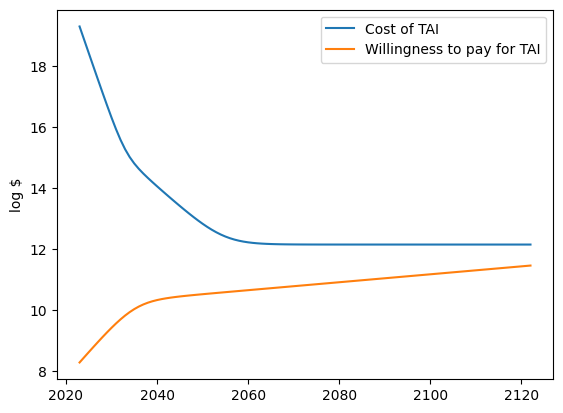

-
-
## SAMPLE RUN 46 ##
It takes 24.2 log FLOP (~2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 24.2 log FLOP (2 septillion) - log $ 5.9 to buy TAI (794 thousand) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not 

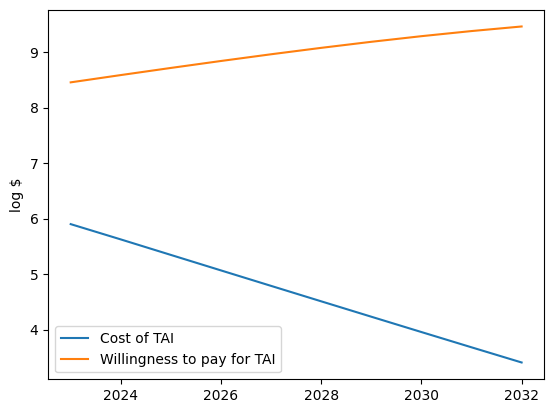

-
-
## SAMPLE RUN 47 ##
It takes 34.9 log FLOP (~79 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~936 million). This doubles every 1.4 years to a max of 0.063474% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.6 to buy TAI (40 quadrillion) vs. willingness to pay log $ 8.9 (880 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (4 octillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.3 to buy TAI (19 quadrillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

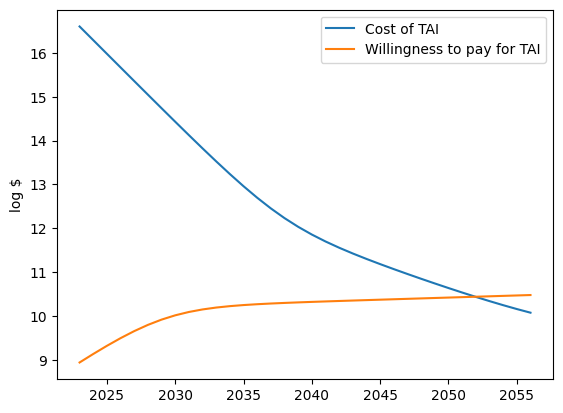

-
-
## SAMPLE RUN 48 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.8 (604 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3

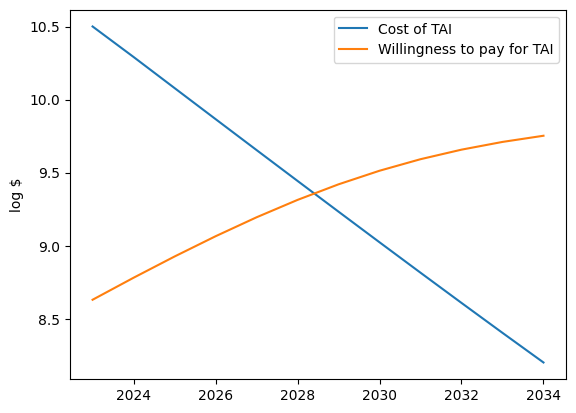

-
-
## SAMPLE RUN 49 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.6 years to a max of 0.078938% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (66 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.6)


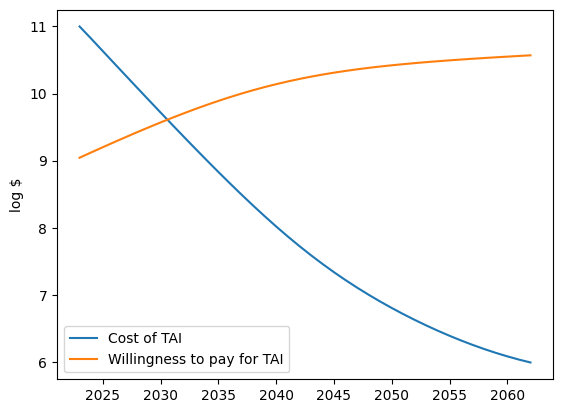

-
-
## SAMPLE RUN 50 ##
It takes 39.9 log FLOP (~8 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.1 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~198 million). This doubles every 3.2 years to a max of 0.104229% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.6 max log FLOP (391 septillion) available - TAI takes 39.9 log FLOP (8 million decillion) - log $ 21.6 to buy TAI (4 sextillion) vs. willingness to pay log $ 8.3 (196 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (596 septillion) available - TAI takes 39.6 log FLOP (4 million decillion) - log $ 21.2 to buy TAI (2 sextillion) vs. willingness to pay log $ 8.4 (243 million) - 18.4 log FLOP per $ (2 quintillion

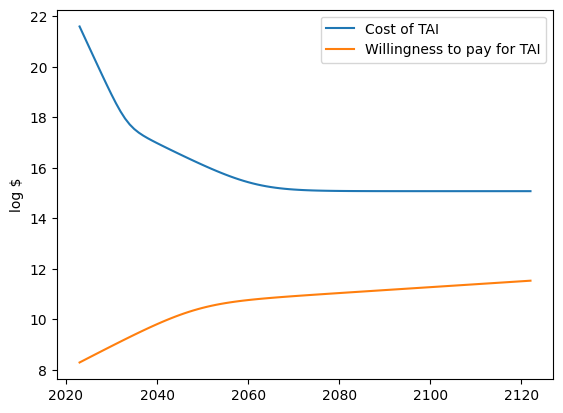

-
-
## SAMPLE RUN 51 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~877 quintillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (159 million) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 10 years)
-- data p_nons

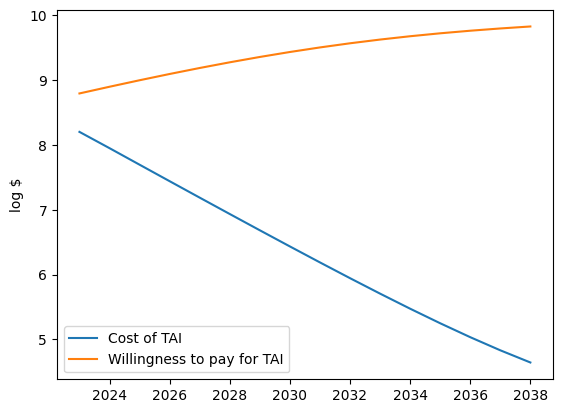

-
-
## SAMPLE RUN 52 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.0 years until 2025, and then doubles every 1.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.9 to buy TAI (79 million) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4

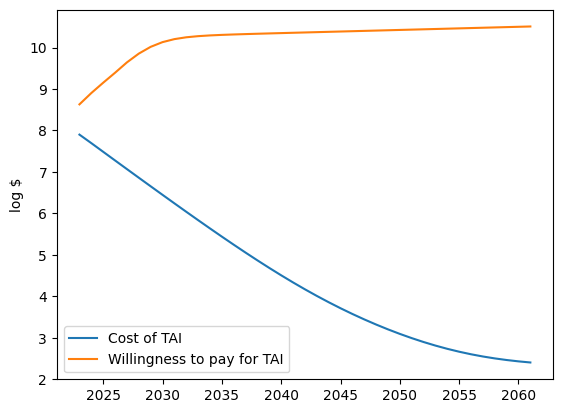

-
-
## SAMPLE RUN 53 ##
It takes 24.1 log FLOP (~1 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 4.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 24.1 log FLOP (1 septillion) - log $ 5.8 to buy TAI (631 thousand) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscal

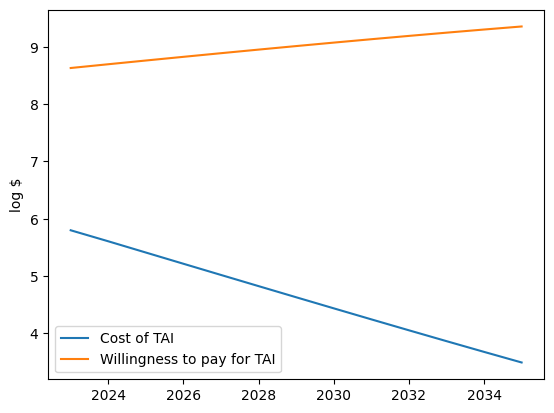

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)